# Genres and modularity

Modularity describes the structure of a network. It can be used to measure how strongly a network is divided into communities.
High modularity implies that the communities in the network is dense, while the connections between communities are sparse.


In [58]:
import networkx as nx
import numpy as np
import requests
import matplotlib.pyplot as plt
from collections import Counter
from io import BytesIO
import re
from collections import defaultdict
import random
import pandas as pd
from networkx.algorithms.community import louvain_communities
from wordcloud import WordCloud


url = "https://raw.githubusercontent.com/fridapfrandsen/network-data/main/rock_network.gexf"

response = requests.get(url)
response.raise_for_status()

G = nx.read_gexf(BytesIO(response.content))

Getting the undirected grahp and removing nodes without genre information

In [59]:
G = G.to_undirected()

nodes_without_genre = [node for node, data in G.nodes(data=True) if "genres" not in data or not data["genres"]]

G.remove_nodes_from(nodes_without_genre)

---
# Part 2: Genres and communities and plotting
---
## Genres and modularity

We wish to partition the network into communities.

As a first approach, we use the genres listed for each artist as a predefined way of grouping them.
Since many artists are associated with multiple genres, we create two partitions:
one using the first listed genre, and one where we assign a random genre from the artist’s list.

We then calculate the modularity of each partition to evaluate how well these genre-based partitions align with the network’s actual community structure.

In [60]:
# Based on the first genre
genre_part = {}
for n, data in G.nodes(data=True):
    genres = data.get("genres")
    if not genres or not isinstance(genres, str):
        continue

    cleaned = re.sub(r"[\*\n\r\t]+", " ", genres.lower())
    parts = [p.strip() for p in cleaned.split(",") if p.strip()]

    if parts:
        genre_part[n] = parts[0] 

# Splitting into communities
genre_comm = defaultdict(list)
for node, genre in genre_part.items():
    genre_comm[genre].append(node)


# Based on a random genre
genre_part_random = {}

for n, data in G.nodes(data=True):
    genres = data.get("genres")
    if not genres or not isinstance(genres, str):
        continue

    cleaned = re.sub(r"[\*\n\r\t]+", " ", genres.lower())
    parts = [p.strip() for p in cleaned.split(",") if p.strip()]

    if parts:
        genre_part_random[n] = random.choice(parts)

# Splitting into communities
genre_comm_random = defaultdict(list)
for node, genre in genre_part_random.items():
    genre_comm_random[genre].append(node)


Computing the modularity:

In [61]:
# Function to calculate modularity
def Modularity(G, partition):
    if isinstance(partition, dict):
        communities = list(partition.values())
    else:
        communities = partition
    M = 0
    L = G.number_of_edges()
    deg = dict(G.degree())
    for nodes in communities:
        subG = G.subgraph(nodes)
        L_c = subG.number_of_edges()
        k_c = sum(deg[n] for n in nodes)
        M += (L_c / L) - (k_c / (2 * L)) ** 2
    return M

In [62]:
# Calculating number of links and nodes in each community and finding the sum
M = Modularity(G, genre_comm)
M_random = Modularity(G, genre_comm_random)

print(f"Modularity (first genre):  {M:.4f}")
print(f"Modularity (random genre): {M_random:.4f}")

Modularity (first genre):  0.0983
Modularity (random genre): 0.0367


The modularity values of both partitions are very low, indicating that grouping the network by genre does not produce a clear community structure.

This suggests that genre alone is too simplistic for partitioning the network. Other factors, such as the active years of the artist or the geographical origin, may play a more significant role in shaping the actual communities observed in the network.

## Communities and modularity

We now partition the network into communities based on the Louvain algorithm and compute the modularity in order to determine how well a partition it is.

In [63]:
louv_comm = louvain_communities(G, seed=42)
print(f"Number of communities: {len(louv_comm)}")

M_louvain = Modularity(G, louv_comm)
print(f"Modularity (Louvain communities): {M_louvain:.4f}")

Number of communities: 7
Modularity (Louvain communities): 0.3257


We observe that the modularity is much higher when using the Louvain algorithm for partitioning.

This indicates that the Louvain method successfully detects communities that reflect the actual structure of the network.

We will use this partition — dividing the network into seven communities — for the subsequent analysis.

## Communities vs. genres

We compute the confusion matrix D to see if the detected communities overlap with the genres.

In [64]:
# Top 7 genres
all_genres = []
for _, data in G.nodes(data=True):
    genres = data.get("genres")
    if isinstance(genres, str):
        genres = [g.strip().lower().replace("*", "") for g in genres.split(",") if g.strip()]
    if genres:
        all_genres.extend(genres)

# Biggest 7 communites
communities = sorted(louv_comm, key=len, reverse=True)
top_comms = communities[:7]

top_genres = [g for g, _ in Counter(all_genres).most_common(7)]
print("Top genres:", top_genres)
print("Top community sizes:", [len(c) for c in top_comms])

node_to_comm = {}
for j, comm in enumerate(top_comms):
    for n in comm:
        node_to_comm[n] = j

matrix = pd.DataFrame(0, index=top_genres, columns=[f"C{j}" for j in range(len(top_comms))])

for n, data in G.nodes(data=True):
    if n not in node_to_comm:
        continue 
    genres = data.get("genres")
    if isinstance(genres, str):
        genres = [g.strip().lower().replace("*", "") for g in genres.split(",") if g.strip()]
    if not genres:
        continue
    for g in genres:
        if g in top_genres:
            matrix.loc[g, f"C{node_to_comm[n]}"] += 1

display(matrix)

Top genres: ['alternative rock', 'hard rock', 'pop rock', 'rock', 'alternative metal', 'blues rock', 'pop']
Top community sizes: [130, 99, 89, 82, 69, 4, 1]


,C0,C1,C2,C3,C4,C5,C6
alternative rock,8,35,1,52,44,0,0
hard rock,12,24,46,7,50,0,0
pop rock,28,22,25,20,11,0,0
rock,57,0,26,8,2,1,1
alternative metal,0,26,0,1,33,0,0
blues rock,23,1,18,3,5,0,0
pop,32,2,11,5,0,0,0


The confusion matrix shows that the detected communities only partially align with the artists’ genres.

Most genres are distributed across several communities, indicating that genre alone does not fully explain the structure of the network.

However, certain patterns emerge — for example, hard rock and alternative metal are concentrated in community C4, while pop and rock appear more frequently in C0.

This suggests that while the Louvain algorithm captures some genre-based clustering, other factors also play an important role in shaping the network structure.

## Plot of the communities

Lastly we plot the network with the communities we detected colorcoded:

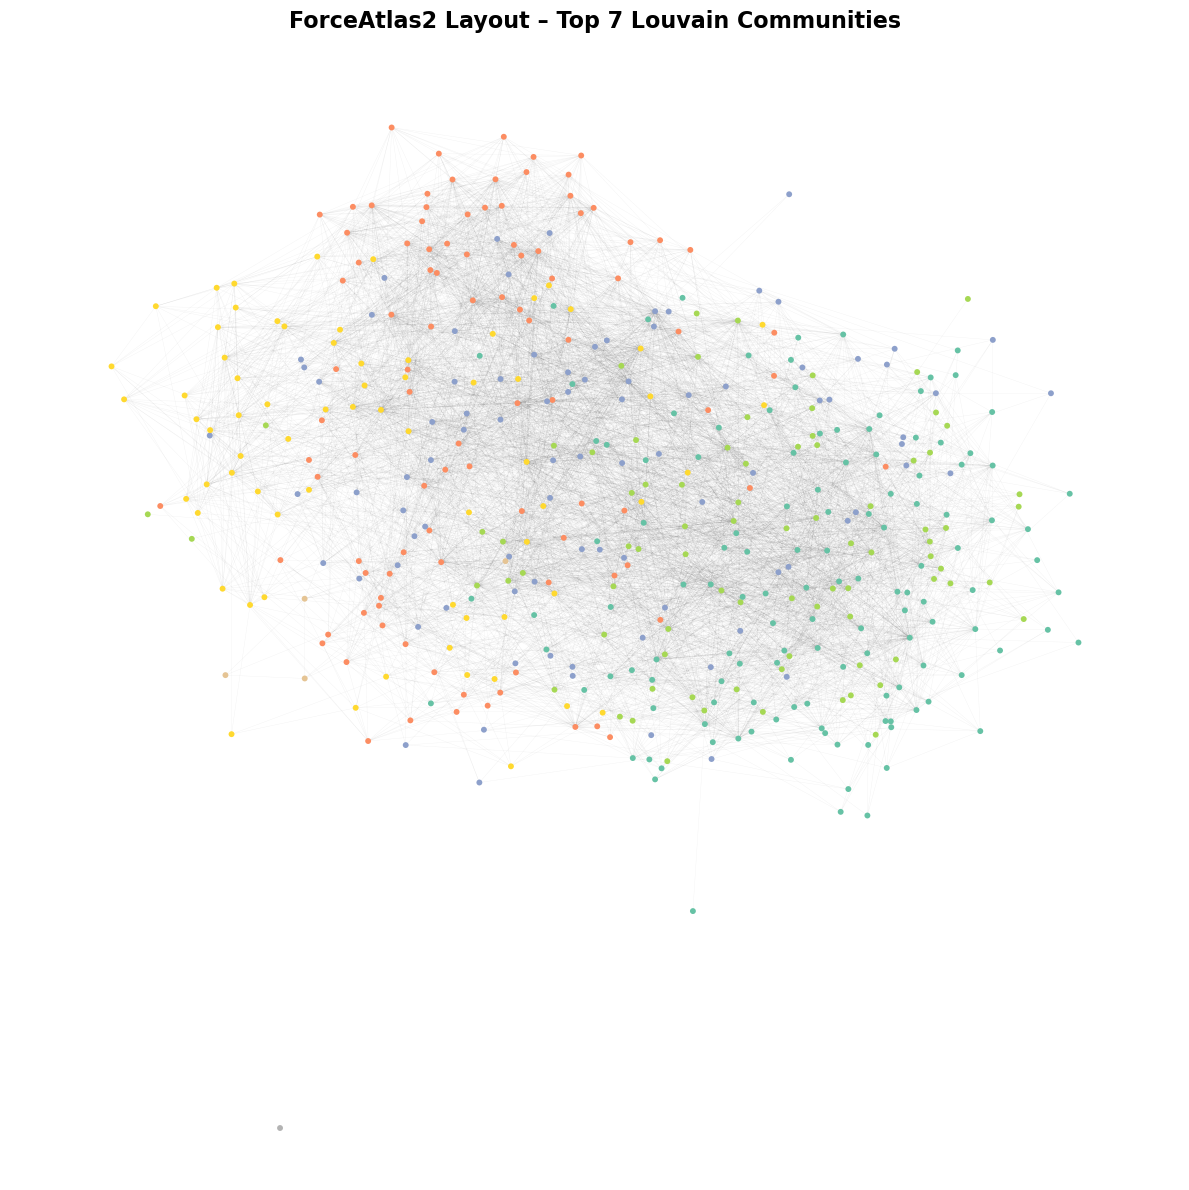

In [97]:
pos = nx.forceatlas2_layout(G, gravity=1.0, seed=55)

top_nodes = set().union(*top_comms)

# Coloring
colors = plt.cm.Set2(np.linspace(0, 1, len(top_comms)))
color_map = {}
for i, comm in enumerate(top_comms):
    for node in comm:
        color_map[node] = colors[i]

node_colors = [color_map.get(n, (0.8, 0.8, 0.8, 0.25)) for n in G.nodes()]

# Plot
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.3, edge_color="black")
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=18,
    node_color=node_colors,
    linewidths=0.1,
    edgecolors="none",
)
plt.title("ForceAtlas2 Layout – Top 7 Louvain Communities", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

Looking at the plot we can observe that there is some clustering of the community, but there is still very much overlap between the colors, suggesting that the network is highly interconnected, meaning the artists tend to connect accros many factors. 

The plot aligns with the modularity value of 0.33 which indicate that even though there is some community structure, their is also a lot of cross-community links.

---
# Part 3: TF-IDF to understand genres and communities
---

**Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.**

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
top_genres = [g for g, _ in Counter(all_genres).most_common(15)]
texts_by_genre = defaultdict(list)

for node, data in G.nodes(data=True):
    text = data.get("wikitext")
    genres_str = data.get("genres") 
    if genres_str:
        genres_list = [g.strip().lower() for g in genres_str.split(",")]
        for g in genres_list:
            if g in top_genres: 
                texts_by_genre[g].append(text)




genre_docs = {g: " ".join(texts_by_genre[g]) for g in top_genres}

custom_stopwords = [
    "band", "album", "song", "music", "released", "years", "group", "artist",
    "record", "studio", "single", "tracks", "performed", "songs", "recorded",
    "label", "band's", "rock", "tour", "category", "new", "number", "time"
]

vectorizer = TfidfVectorizer(
    stop_words='english',  
    max_features=5000
)

vectorizer = TfidfVectorizer(
    stop_words=custom_stopwords + list(vectorizer.get_stop_words()),
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform([genre_docs[g] for g in top_genres])
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=top_genres,
    columns=vectorizer.get_feature_names_out()
)

tfidf_df.head()

### for comunities

texts_by_comm = {}

for i, comm in enumerate(top_comms):
    all_text = []

    for node in comm:
        text = G.nodes[node].get("wikitext", "")
        if text:
            all_text.append(text)

    texts_by_comm[f"community_{i}"] = " ".join(all_text)


docs = list(texts_by_comm.values())
comm_names = list(texts_by_comm.keys())


vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

vectorizer = TfidfVectorizer(
    stop_words=custom_stopwords + list(vectorizer.get_stop_words()),
    max_features=5000
)

tfidf_matrix = vectorizer.fit_transform(docs)
tfidf_df_comm = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=comm_names,
    columns=vectorizer.get_feature_names_out()
)




In [67]:
top_words_genre = {}

for genre in top_genres:
    sorted_words = tfidf_df.loc[genre].sort_values(ascending=False)
    top_words_genre[genre] = sorted_words.head(10)
    print(f"\n--- {genre} ---")
    print(top_words_genre[genre])


top_words_comm = {}

for comm in comm_names:
    sorted_words = tfidf_df_comm.loc[comm].sort_values(ascending=False)
    top_words_comm[comm] = sorted_words.head(10)
    print(f"\n--- {comm} ---")
    print(top_words_comm[comm])



--- alternative rock ---
best         0.157681
live         0.140800
year         0.138442
guitar       0.131558
video        0.127786
awards       0.125711
release      0.125522
announced    0.117883
vocals       0.115620
records      0.109962
Name: alternative rock, dtype: float64

--- hard rock ---
live         0.160657
guitar       0.158864
vocals       0.146613
lead         0.124203
year         0.121613
musical      0.119820
albums       0.118028
announced    0.117131
release      0.110657
records      0.110259
Name: hard rock, dtype: float64

--- pop rock ---
vocals      0.173102
best        0.146619
year        0.136989
live        0.135424
guitar      0.134943
uk          0.125914
american    0.119414
records     0.113756
albums      0.111830
awards      0.110265
Name: pop rock, dtype: float64

--- rock ---
guitar      0.153434
american    0.148649
year        0.131033
vocals      0.129620
records     0.128097
live        0.123204
uk          0.119833
later       0.115592
bes

In [68]:
n = len(top_genres)
cols = 3  # number of columns
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*6, rows*4))

for i, genre in enumerate(top_genres):
    scores = tfidf_df.loc[genre]
    scaled_scores = scores / scores.max()  # scale 0–1

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',  # white background
        colormap='plasma',         # change colors
    ).generate_from_frequencies(scaled_scores.to_dict())

    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(genre, fontsize=12)

plt.tight_layout()
plt.show()


NameError: name 'math' is not defined

In [70]:

n = len(comm_names)
cols = 3
rows = math.ceil(n / cols)

plt.figure(figsize=(cols*6, rows*4))

for i, comm in enumerate(comm_names):
    scores = tfidf_df_comm.loc[comm]
    scaled_scores = scores / scores.max()  # 0–1 scaling

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='plasma'
    ).generate_from_frequencies(scaled_scores.to_dict())

    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(comm, fontsize=12)

plt.tight_layout()
plt.show()

NameError: name 'math' is not defined

---
# Part 4: Sentiment of the artists and communities
---

We first fetch the LabMT wordlist:

In [ ]:
labmt_url = "https://raw.githubusercontent.com/fridapfrandsen/network-data/main/Data_Set_S1.txt"

response_labmt = requests.get(labmt_url)
response_labmt.raise_for_status()

labmt = pd.read_csv(BytesIO(response_labmt.content), sep="\t", skiprows=2)
labmt_dict = dict(zip(labmt["word"], labmt["happiness_average"]))

We wish to be able to determine the sentiment of a text based on the word list from LabMT.

First we make a function to calculate the sentiment:

In [71]:
def calc_sentiment(tokens):
    scores = []
    for token in tokens:
        token = token.lower()
        if token in labmt_dict:
            scores.append(labmt_dict[token])
    if scores:
        return np.mean(scores)
    else:
        return None

This function can then be used to calculate the wikipediapage of each artist on the list.

We add the sentiment as an attribute to the nodes.

In [72]:
for node, data in G.nodes(data=True):
    text = data.get("wikitext")
    if not text:
        continue
    tokens = re.findall(r"\w+", text.lower())
    sentiment = calc_sentiment(tokens)
    G.nodes[node]["sentiment"] = sentiment

We plot the calculated sentiments in a histogram:

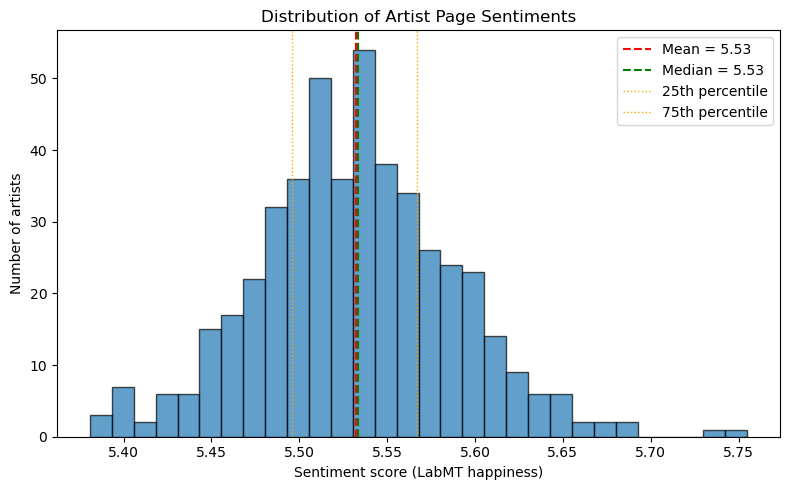

Variance: 0.0032


In [73]:
sentiments = [G.nodes[n]["sentiment"] for n in G.nodes() if not np.isnan(G.nodes[n]["sentiment"])]

mean_sent = np.mean(sentiments)
median_sent = np.median(sentiments)
var_sent = np.var(sentiments)
p25 = np.percentile(sentiments, 25)
p75 = np.percentile(sentiments, 75)

plt.figure(figsize=(8,5))
plt.hist(sentiments, bins=30, edgecolor='black', alpha=0.7)

plt.axvline(mean_sent, color='red', linestyle='dashed', linewidth=1.5, label=f"Mean = {mean_sent:.2f}")
plt.axvline(median_sent, color='green', linestyle='dashed', linewidth=1.5, label=f"Median = {median_sent:.2f}")
plt.axvline(p25, color='orange', linestyle='dotted', linewidth=1, label='25th percentile')
plt.axvline(p75, color='orange', linestyle='dotted', linewidth=1, label='75th percentile')

plt.title("Distribution of Artist Page Sentiments")
plt.xlabel("Sentiment score (LabMT happiness)")
plt.ylabel("Number of artists")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Variance: {var_sent:.4f}")

The sentiment scores for the artists’ Wikipedia pages is distributed normally and centered around a mean of 5.53.

This indicates that the language used in most articles is generally neutral with very little variation across artists, which can be seen by the very small variance.

The small range suggests that there are no strong outliers and that the sentiment is relatively consistent across the dataset.

## Community level sentiment

Next we calculate the sentiments on a community level using our sentiment calculater function from earlier.

In [90]:
comm_sentiments = {}

for name, text in texts_by_comm.items():
    tokens = re.findall(r"\w+", text.lower())
    sentiment = calc_sentiment(tokens)
    comm_sentiments[name] = sentiment

We compile the results into a single dataframe that summarizes each community.

For every community, we list the three most connected artists (based on degree centrality), the most dominant genres within the group, and the average sentiment value calculated from the artists’ Wikipedia pages.

In [89]:
deg_cent = nx.degree_centrality(G)

community_info = []

for i, comm in enumerate(louv_comm):
    comm_deg = {n: deg_cent[n] for n in comm}
    top3 = sorted(comm_deg.items(), key=lambda x: x[1], reverse=True)[:3]
    top3_names = [n.replace("_", " ") for n, _ in top3]

    all_genres = []
    for node in comm:
        g = G.nodes[node].get("genres")
        if isinstance(g, str):
            parts = [p.strip().lower() for p in re.split(r",|;|\s{2,}", g) if p.strip()]
            all_genres.extend(parts)
    common_genres = [g for g, _ in Counter(all_genres).most_common(1)]

    community_info.append({
        "Community": f"C{i}",
        "Top bands": ", ".join(top3_names),
        "Top genres": ", ".join(common_genres),
    })

community_df = pd.DataFrame(community_info)
sentiment_values = list(comm_sentiments.values())
community_df["Sentiment"] = sentiment_values
community_df

,Community,Top bands,Top genres,Sentiment
0,C0,"Sly and the Family Stone, Funkadelic, Parliame...",funk rock,5.530179
1,C1,"Queen (band), Deep Purple, Alice Cooper",hard rock,5.502776
2,C2,"David Bowie, U2, Nirvana (band)",alternative rock,5.521214
3,C3,"Metallica, Black Sabbath, Kiss (band)",alternative rock,5.539474
4,C4,"Bob Dylan, Jimi Hendrix, Elton John",rock,5.528132
5,C5,"Led Zeppelin, Guns N' Roses, Alice in Chains",hard rock,5.505230
6,C6,Tommy James and the Shondells,rock,5.489391


**Mangler at kommentere på sentiment værdierne ud fra TF-IDF**